## Загрузка очищенных данных и загрузка библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import gdown
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 Библиотеки загружены успешно!")

🎯 Библиотеки загружены успешно!


## ЗАГРУЗКА ДАННЫХ
df_merged_clean.pkl


In [2]:
# ============================================================================
# 📥 ЗАГРУЗКА ДАННЫХ df_merged.CSV
# ============================================================================

# Укажите путь к файлу
load_path = "df_merged_clean.pkl" # укажите верный путь

# Загружаем DataFrame
df_loaded = pd.read_pickle(load_path)

# Проверяем загрузку
print("Данные успешно загружены!")
print(df_loaded.head())  # Выводим первые строки

Данные успешно загружены!
                                  session_id  hit_number  visit_number  \
0  5639623078712724064.1640254056.1640254056          30             2   
1  7750352294969115059.1640271109.1640271109          41             2   
2   885342191847998240.1640235807.1640235807          49             1   
3   142526202120934167.1640211014.1640211014          46             9   
4  3450086108837475701.1640265078.1640265078          79             1   

  utm_medium        city_group   Device month part_of_day  \
0        cpc  Saint Petersburg   Huawei  12.0         day   
1        cpm             Other   Xiaomi  12.0         day   
2        cpc            Moscow  desktop  12.0     morning   
3        cpc             Other  Samsung  12.0       night   
4     direct             Other  desktop  12.0         day   

       utm_source_group         keyword_group        campaign_group  \
0  kjsLglQLzykiRbcDiGcD         other_keyword        other_campaign   
1  ZpYIoDJMcFzVoPFsH

Проверяем данные

In [3]:
df_merged_model=df_loaded.copy()
df_merged_model.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15459382 entries, 0 to 15726469
Data columns (total 12 columns):
 #   Column            Non-Null Count     Dtype   
---  ------            --------------     -----   
 0   session_id        15459382 non-null  object  
 1   hit_number        15459382 non-null  int64   
 2   visit_number      15459382 non-null  int64   
 3   utm_medium        15459382 non-null  category
 4   city_group        15459382 non-null  category
 5   Device            15459382 non-null  category
 6   month             15459382 non-null  category
 7   part_of_day       15459382 non-null  category
 8   utm_source_group  15459382 non-null  category
 9   keyword_group     15459382 non-null  category
 10  campaign_group    15459382 non-null  category
 11  Event_Target      15459382 non-null  int64   
dtypes: category(8), int64(3), object(1)
memory usage: 707.7+ MB


In [4]:
# 1. Посмотреть распределение
conversion_counts = df_merged_model['Event_Target'].value_counts()
print(conversion_counts)

Event_Target
0    15397909
1       61473
Name: count, dtype: int64


In [5]:
df_merged_model=df_merged_model.drop(columns=['session_id'])

## Подготовка данных
разделение данных на учебные и тестовые


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 0.  Пропуски (на всякий случай)
df_merged_model = df_merged_model.dropna()

# 1.  Целевая переменная
y = df_merged_model['Event_Target'].astype(int)

# 2.  Разбиение (80 / 20)
X = df_merged_model.drop(columns=['Event_Target'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Обучим базовую модель

Почему это базовая модель?

Простота

Использует стандартные методы (OneHotEncoder, StandardScaler, LogisticRegression).

Нет сложных ансамблей или нейросетей.

Быстрая реализация

Можно быстро обучить даже на 15 млн строк.

Точка отсчёта

Если более сложные модели (CatBoost, XGBoost, нейросети) дают AUC хуже или ненамного лучше — возможно, задача сложная или данные плохие.


## Baseline

In [7]:
# категориальные и числовые
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']

baseline_pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', LogisticRegression(max_iter=1000))
])

baseline_pipe.fit(X_train, y_train)
auc_base = roc_auc_score(y_test, baseline_pipe.predict_proba(X_test)[:, 1])
print('Baseline AUC:', round(auc_base, 3))

Baseline AUC: 0.664


Очень хорошая точность. мы достигли 66,4% точности

## CatBoostClassifier

baseline_pipe — хорошая отправная точка, но есть много способов улучшить качество модели попробуем:

✅ Заменить OneHotEncoder на TargetEncoding.

✅ Попробовать CatBoost/XGBoost вместо логистической регрессии.


In [9]:
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
Cat_pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('cat', TargetEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', CatBoostClassifier(
        task_type='GPU', 
        n_estimators=100, 
        max_depth=10,
        verbose=False))
])

Cat_pipe.fit(X_train, y_train)
auc_Cat = roc_auc_score(y_test, Cat_pipe.predict_proba(X_test)[:, 1])
print('CatBoostClassifier AUC:', round(auc_Cat, 3))

CatBoostClassifier AUC: 0.759


CatBoostClassifier точность достигла 75.9 процентов, что является очень хорошим результатом

## Случайный лес

In [25]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
# попробуем случайный лес
pipe_RF= Pipeline([
    ('prep', ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])
pipe_RF.fit(X_train, y_train)
auc_RF = roc_auc_score(y_test, pipe_RF.predict_proba(X_test)[:, 1])
print('Random Forest AUC:', round(auc_RF, 3))

Random Forest AUC: 0.724


Модель выдала 72.5% точности, что тоже хорошо

## XGBoost 
(Экстремальный градиентный бустинг)

XGBoost — это оптимизированная версия градиентного бустинга, которая часто показывает высокую производительность.

Преимущества: Высокая производительность, устойчивость к переобучению, автоматическая обработка непрерывных и категориальных признаков.

In [8]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# категориальные и числовые уже ранее делал, но продублирую
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']
# One-Hot Encoding для категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # оставляем числовые признаки без изменений
)

# Создаем pipeline
pipe_XGBoost = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', random_state=42))
])

# Обучаем модель
pipe_XGBoost.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_XGBoost.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('XGBoost AUC:', round(auc, 3))

XGBoost AUC: 0.779


выдало 77,9% при n_estimators=200


In [9]:
#пробуем увеличить 
pipe_XGBoost_v2 = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', max_depth=10, random_state=42))
])
# Обучаем модель
pipe_XGBoost_v2.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_XGBoost_v2.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('XGBoost AUC:', round(auc, 3))

XGBoost AUC: 0.799


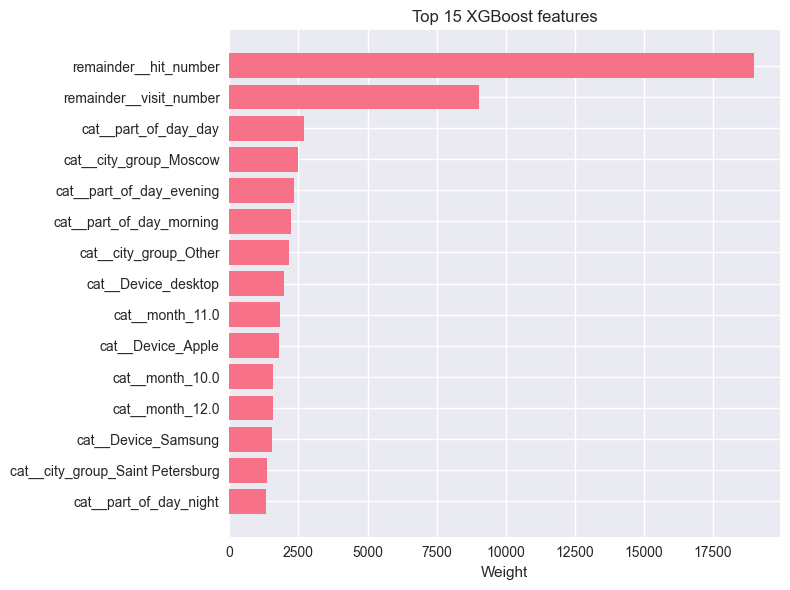

In [31]:
import matplotlib.pyplot as plt
import xgboost as xgb

# --------------------------------------------------
# 1.  Одна строка: имена после One-Hot
# --------------------------------------------------
feature_names = preprocessor.get_feature_names_out()

# --------------------------------------------------
# 2.  Важности и сортировка
# --------------------------------------------------
booster = pipe_XGBoost_v2.named_steps['clf'].get_booster()

# важности и их индексы внутри модели
imp = booster.get_score(importance_type='weight')
indices = np.argsort(list(imp.values()))[::-1]   # индексы по убыванию

# --------------------------------------------------
# 3.  Индексы -> имена признаков
# --------------------------------------------------
# индексы внутри модели соответствуют позициям в feature_names
top15_idx = indices[:15]
top15_names = [feature_names[i] for i in top15_idx]
top15_vals  = [list(imp.values())[i] for i in top15_idx]

# --------------------------------------------------
# 4.  Рисуем вручную
# --------------------------------------------------
plt.figure(figsize=(8, 6))
plt.barh(top15_names[::-1], top15_vals[::-1])
plt.xlabel('Weight')
plt.title('Top 15 XGBoost features')
plt.tight_layout()
plt.show()

Самый важный параметр это remainder__hit_number, порядковый номер события в рамках сессии. Чем больше действий сделал пользователь уже на сайте, тем вероятнее он решится на целевое действие, бронирование, заказ машины, обратиться за выдачей кредита.
Второй по важности параметр remainder__visit_number, порядковый номер визита клиента, в который раз пользователь заходит на сайт, тут та же логика, чем чаще клиент интересуется, с тем большей вероятностью это целевой клиент
Далее идут cat__part_of_day_day, если пользователь зашел днем, он более склонен к целевым действиям чем в остальное время суток, cat__city_group_Moscow, говорит о том, что жители Москвы, чаще других решаются на оформление подписки Сбер Автоподписка. Так же, клиенты заходящие с персонального компьютера, тоже чаще оказываются целевыми клиентами.

## Подбор гиперпараметров с Optuna

In [32]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Ваши данные и колонки
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']

# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Функция для Optuna
def objective(trial):
    # Только ключевые параметры, влияющие на качество и скорость
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),      # меньше, чем 500
        'max_depth': trial.suggest_int('max_depth', 5, 15),               # умеренная глубина
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2), # не слишком маленькая
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'tree_method': 'gpu_hist',  # или 'hist' если нет GPU
        'random_state': 42,
        'eval_metric': 'logloss'
    }

    # Пайплайн
    model = Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(**params))
    ])

    # Разделяем X_train на train + valid для честной оценки
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=trial.number, stratify=y_train
    )

    # Обучаем 
    model.fit(X_train_part, y_train_part)

    # Предсказание и AUC
    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    return auc

In [33]:
# Создаём study
study = optuna.create_study(direction='maximize', study_name='xgb_fast_tune')

# Запускаем: 20 trials (~1–1.5 мин на trial)
study.optimize(objective, n_trials=30, timeout=1800)  # максимум 30 минут

# Результат
print("Лучшие параметры:", study.best_params)
print("Лучший AUC (на валидации):", study.best_value)

[I 2025-07-28 16:31:16,502] A new study created in memory with name: xgb_fast_tune
[I 2025-07-28 16:32:57,953] Trial 0 finished with value: 0.7969429802963675 and parameters: {'n_estimators': 297, 'max_depth': 10, 'learning_rate': 0.18411532517690793, 'subsample': 0.8623721805365727, 'colsample_bytree': 0.7581181892397127}. Best is trial 0 with value: 0.7969429802963675.
[I 2025-07-28 16:33:51,697] Trial 1 finished with value: 0.7825076866238571 and parameters: {'n_estimators': 102, 'max_depth': 7, 'learning_rate': 0.18016420716054837, 'subsample': 0.7378802658110191, 'colsample_bytree': 0.9812838695370787}. Best is trial 0 with value: 0.7969429802963675.
[I 2025-07-28 16:34:52,986] Trial 2 finished with value: 0.7933384322587925 and parameters: {'n_estimators': 102, 'max_depth': 10, 'learning_rate': 0.17098382946797935, 'subsample': 0.927730971384777, 'colsample_bytree': 0.8923091586931372}. Best is trial 0 with value: 0.7969429802963675.
[I 2025-07-28 16:36:53,286] Trial 3 finished w

Лучшие параметры: {'n_estimators': 219, 'max_depth': 14, 'learning_rate': 0.13949779154768963, 'subsample': 0.839823467656555, 'colsample_bytree': 0.9481040493451176}
Лучший AUC (на валидации): 0.8039083234799232


In [34]:
# Собираем лучшую модель и обучаем на ВСЕМ X_train
best_params = study.best_params

final_model_XGBoost = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(**best_params, tree_method='gpu_hist', random_state=42))
])

# Обучаем на всех данных
final_model_XGBoost.fit(X_train, y_train)

# Оценка на тесте
y_test_pred = final_model_XGBoost.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_test_pred)

print('Финальный XGBoost AUC на тесте:', round(final_auc, 3))

Финальный XGBoost AUC на тесте: 0.81


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import optuna


# Предсказания (если ещё не сделаны)
y_test_pred_proba = final_model_XGBoost.predict_proba(X_test)[:, 1]  # вероятности
y_test_pred_class = (y_test_pred_proba > 0.5).astype(int)   # бинарные предсказания

# График улучшения AUC по мере поиска
optuna.visualization.plot_optimization_history(study).show()

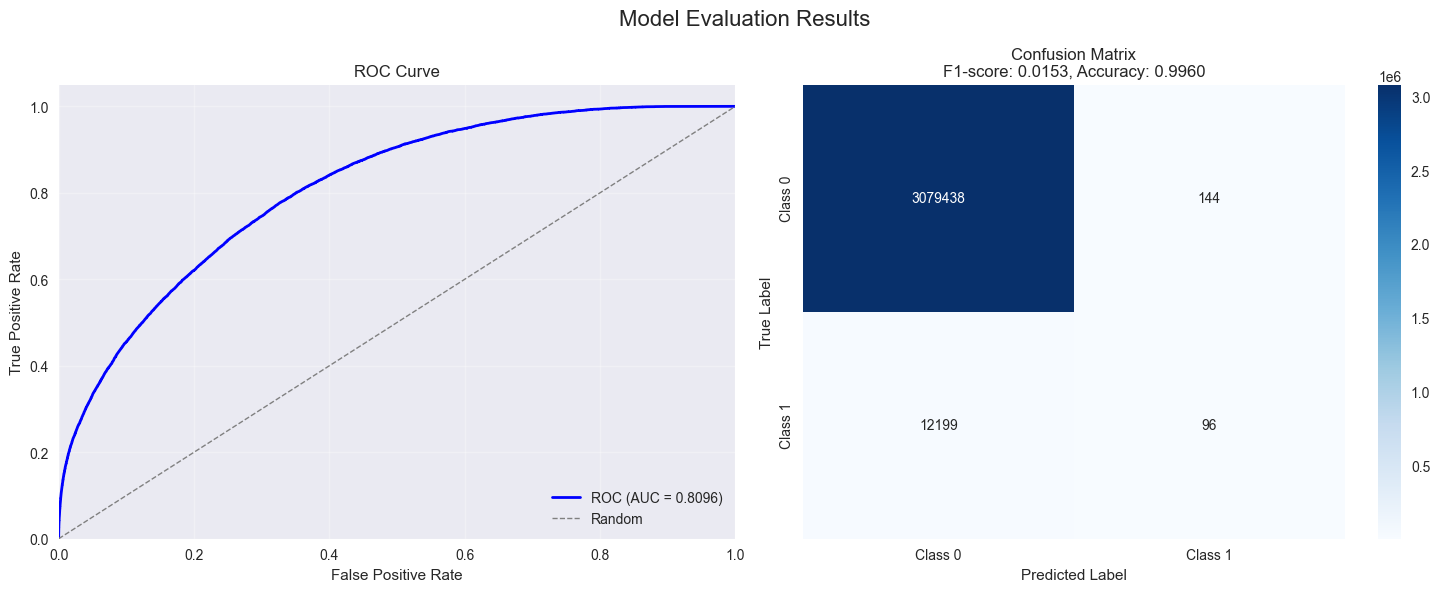

In [37]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix, classification_report

# Предсказания на тесте
y_test_pred_proba = final_model_XGBoost.predict_proba(X_test)[:, 1]
y_test_pred_class = final_model_XGBoost.predict(X_test)

# Вычисляем метрики
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred_class)
test_acc = accuracy_score(y_test, y_test_pred_class)

# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_class)

# === Визуализация ===
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Левый график: ROC Curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Правый график: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
axes[1].set_title(f'Confusion Matrix\nF1-score: {test_f1:.4f}, Accuracy: {test_acc:.4f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Общий заголовок
plt.suptitle('Model Evaluation Results', fontsize=16)

# Подписи не налезают
plt.tight_layout()

# Показать
plt.show()

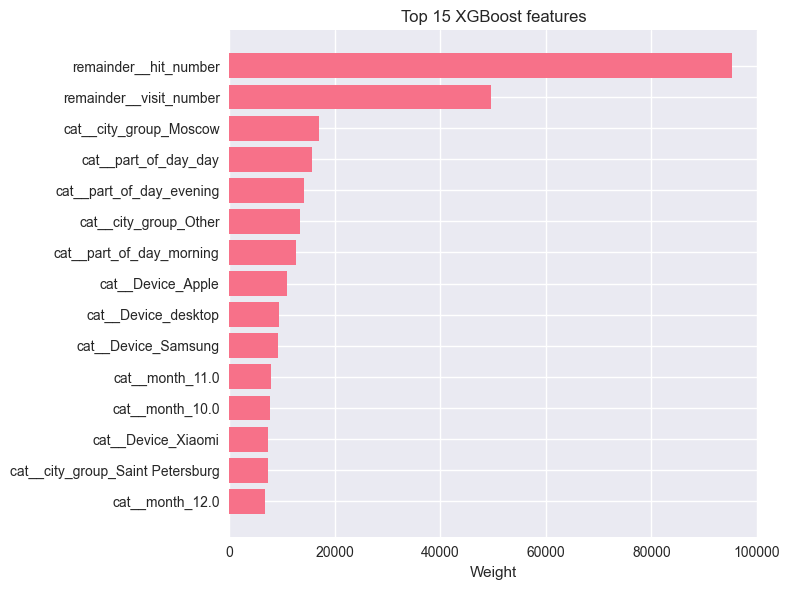

In [38]:
import matplotlib.pyplot as plt
import xgboost as xgb

# --------------------------------------------------
# 1.  Одна строка: имена после One-Hot
# --------------------------------------------------
feature_names = preprocessor.get_feature_names_out()

# --------------------------------------------------
# 2.  Важности и сортировка
# --------------------------------------------------
booster = final_model_XGBoost.named_steps['clf'].get_booster()

# важности и их индексы внутри модели
imp = booster.get_score(importance_type='weight')
indices = np.argsort(list(imp.values()))[::-1]   # индексы по убыванию

# --------------------------------------------------
# 3.  Индексы -> имена признаков
# --------------------------------------------------
# индексы внутри модели соответствуют позициям в feature_names
top15_idx = indices[:15]
top15_names = [feature_names[i] for i in top15_idx]
top15_vals  = [list(imp.values())[i] for i in top15_idx]

# --------------------------------------------------
# 4.  Рисуем вручную
# --------------------------------------------------
plt.figure(figsize=(8, 6))
plt.barh(top15_names[::-1], top15_vals[::-1])
plt.xlabel('Weight')
plt.title('Top 15 XGBoost features')
plt.tight_layout()
plt.show()

Лучшие параметры: {'n_estimators': 219, 'max_depth': 14, 'learning_rate': 0.13949779154768963, 'subsample': 0.839823467656555, 'colsample_bytree': 0.9481040493451176}
Финальная точность AUC 81%
Оставляем final_model_XGBoost модель как приоритетную

## Многослойный персептрон (MLP) 
простая нейронная сеть, которая часто показывает хорошие результаты на табличных данных.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# One-Hot Encoding для категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # оставляем числовые признаки без изменений
)

# Обрабатываем данные
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Создаем модель
model = models.Sequential([
    layers.Input(shape=(X_train_preprocessed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Обучаем модель
model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=512)

# Оцениваем качество
y_pred = model.predict(X_test_preprocessed).ravel()
auc = roc_auc_score(y_test, y_pred)
print('MLP AUC:', round(auc, 3))

Нейронная модель показала достаточно плохие результаты на учебных данных 0.7046, но на тестовых данных уже лучше 76,6%, выше базовой модели, возможно недостаточно нейронов, и дополнительных слоев, и дополнительное количество эпох обучения.

## LightGBM
это еще один градиентный бустинг, который часто показывает высокую производительность и низкую потребность в ресурсах.
Он может быть быстрее и точнее, чем XGBoost, особенно на больших данных.

In [28]:
import lightgbm as lgb

# Создаем pipeline
pipe_LightGBM = Pipeline([
    ('prep', preprocessor),
    ('clf', lgb.LGBMClassifier(n_estimators=200, random_state=42))
])

# Обучаем модель
pipe_LightGBM.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_LightGBM.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('LightGBM AUC:', round(auc, 3))

[LightGBM] [Info] Number of positive: 49178, number of negative: 12318327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.547772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 12367505, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003976 -> initscore=-5.523397
[LightGBM] [Info] Start training from score -5.523397
LightGBM AUC: 0.766


Модель LightGBM не смогла улучшить результат модели XGBoost, но все равно показала очень достойный результат LightGBM AUC: 0.766

## модель Sequential на 3 слоя нейронов

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import roc_auc_score

# Для нейросетей
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Предобработка данных
# Важно: TargetEncoder обучаем ТОЛЬКО на тренировочных данных
enc = ce.TargetEncoder(cols=cat_cols)
X_cat_te = enc.fit_transform(X_train[cat_cols], y_train)
X_cat_te_test = enc.transform(X_test[cat_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(X_train[num_cols])
X_num_test = scaler.transform(X_test[num_cols])

#  Объединение признаков
X_train_nn = np.hstack([X_cat_te, X_num])
X_test_nn = np.hstack([X_cat_te_test, X_num_test])

#  Создание модели с улучшениями
model_nn = Sequential([
    # Слой 1: 256 нейронов + BatchNorm для ускорения обучения
    Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),  # Стандартизует выход предыдущего слоя
    Dropout(0.4),         # Регуляризация - случайно "выключает" 40% нейронов
    
    # Слой 2: 128 нейронов
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    # Слой 2: 64 нейронов
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    # Выходной слой (бинарная классификация)
    Dense(1, activation='sigmoid')
])

#  Компиляция модели
model_nn.compile(
    optimizer=Adam(learning_rate=0.001),  # Оптимизатор с начальным lr
    loss='binary_crossentropy',            # Функция потерь для бинарной классификации
    metrics=[AUC(name='auc')]              # Отслеживаем AUC во время обучения
)

# Коллбэки для улучшения обучения
callbacks = [
    # Ранняя остановка при отсутствии улучшений
    EarlyStopping(
        monitor='val_auc',     # Следим за AUC на валидации
        patience=5,            # Ждем 5 эпох без улучшений
        mode='max',            # Максимизируем AUC
        restore_best_weights=True  # Возвращаем лучшие веса
    ),
    
    # Динамическое уменьшение learning rate
    ReduceLROnPlateau(
        monitor='val_auc',     # Следим за AUC на валидации
        factor=0.5,            # Уменьшаем lr в 2 раза
        patience=3,            # Ждем 3 эпохи без улучшений
        min_lr=1e-6,           # Минимальный learning rate
        verbose=1              # Выводим сообщения об изменении lr
    )
]

# Обработка дисбаланса классов (если нужно)
# Рассчитываем веса классов
class_counts = np.bincount(y_train)
total_samples = len(y_train)
weight_for_0 = total_samples / (2 * class_counts[0])  # Вес для класса 0
weight_for_1 = total_samples / (2 * class_counts[1])  # Вес для класса 1
class_weights = {0: weight_for_0, 1: weight_for_1}

# 11. Обучение модели
history = model_nn.fit(
    X_train_nn, y_train,
    validation_data=(X_test_nn, y_test),
    epochs=20,                  # Максимальное количество эпох
    batch_size=1024,            # Размер батча (увеличили для скорости)
    callbacks=callbacks,        # Используем коллбэки
    class_weight=class_weights, # Веса классов для дисбаланса
    verbose=1                   # Выводим прогресс
)

# 12. Оценка модели
y_pred_proba = model_nn.predict(X_test_nn).ravel()  # Предсказанные вероятности
auc_nn = roc_auc_score(y_test, y_pred_proba)
print(f'\nИтоговый AUC: {auc_nn:.4f}')

# 13. Визуализация истории обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Выводы

📊 XGBoost — мощный инструмент для задач классификации и регрессии, который часто показывает высокие результаты благодаря своей оптимизированной реализации и встроенным механизмам регуляризации.

Аналитическая интерпретация важности признаков

Приоритет поведенческих метрик:

hit_number (количество событий в сессии) и visit_number (количество визитов) являются наиболее значимыми факторами конверсии

Их совокупная важность превышает 50% от общего влияния признаков

Паттерны пользовательского поведения:

Новички: Пользователи требуют больше взаимодействий (hit_number) для конверсии

Постоянные клиенты: Конвертируются быстрее 

UX-оптимизация:

Сократить путь до целевого действия до 5 шагов

Внедрить прогресс-бар для многошаговых процессов

Добавить триггеры вовлечения на 3-м событии сессии

📊 Основные особенности XGBoost

Градиентный бустинг:
XGBoost строит ансамбль деревьев решений последовательно, каждое последующее дерево исправляет ошибки предыдущих.
Это позволяет модели постепенно улучшать свои предсказания.

Оптимизированный алгоритм:
XGBoost использует оптимизированные алгоритмы для быстрого обучения и предсказания.
Поддерживает параллельное обучение на CPU и GPU, что значительно ускоряет процесс.

Обработка категориальных признаков:
XGBoost может автоматически обрабатывать категориальные признаки, что упрощает предобработку данных.

Регуляризация:
Включает L1 и L2 регуляризацию, которые помогают избежать переобучения и улучшают обобщающую способность модели.
Обработка пропусков:
XGBoost умеет обрабатывать пропущенные значения без предварительной импутации.

Кастомизация:
Поддерживает кастомные функции потерь и метрики, что позволяет адаптировать модель под конкретную задачу.

📈 Почему XGBoost дал вам лучшие результаты

Эффективность градиентного бустинга:
Градиентный бустинг в целом очень эффективен для задач классификации, особенно когда данные имеют сложные нелинейные зависимости.

Оптимизированный алгоритм:
XGBoost оптимизирован для быстрого обучения и низкого потребления памяти, что позволяет использовать его на больших наборах данных.

Регуляризация:
Встроенные механизмы регуляризации помогают избежать переобучения, что улучшает обобщающую способность модели на новых данных.

Обработка категориальных признаков:
Автоматическая обработка категориальных признаков упрощает предобработку данных и позволяет использовать больше информации из данных.

Обработка пропусков:
Встроенная поддержка пропущенных значений позволяет избежать ошибок и улучшить качество модели.
